# 1.0 Impots

In [1]:
import os
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pycaret.classification as pc
from mlflow.tracking import MlflowClient
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss, f1_score
from mlflow.models.signature import infer_signature
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve

# 2.0 Funções Auxiliares

In [2]:
# Definindo grid
sns.set_style("darkgrid") 

# Função para plotar gráfico de curva de validação.
def plot_curve_validation(model, x, y, param_name, param_range, cv=5, scoring='f1', title_model = ''):

    # Titulo Curva de Validação
    title_model = title_model

    # Calculando a curva de validação usando o F1-score como métrica
    train_scores, test_scores = validation_curve(model, X=x, y=y, param_name=param_name, 
                                                 param_range=param_range, cv=cv, scoring=scoring)

    # Calculando as médias e os desvios padrão dos resultados de treino e teste
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plotando a curva de validação
    plt.figure(figsize=(10, 8))
    plt.plot(param_range, train_mean, label="Training F1-score", color="blue", marker='o')
    plt.plot(param_range, test_mean, label="Cross-validation F1-score", color="green", marker='o')
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="green", alpha=0.2)
    plt.title(f"Validation Curve for {title_model}")
    plt.xlabel(param_name)
    plt.ylabel(f"{scoring}")
    plt.xscale('log')
    plt.legend(loc="best")
    # plt.show()

    # Retorna a referência da figura atual
    return plt.gcf()  

In [3]:
# Função para plotar a matriz de confusão
def plot_confusion_matrix(model, data, target):

    # Prever os resultados do modelo
    predictions = pc.predict_model(model, data=data.drop(target, axis=1))

    # Calcular a matriz de confusão
    cm = confusion_matrix(data[target], predictions['prediction_label'])

    # Normalizar a matriz de confusão
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Criar um DataFrame para a matriz de confusão
    df_cm = pd.DataFrame(cm, index=[0, 1], columns=[0, 1])

    # Plotar a matriz de confusão
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 12})
    plt.title('Matriz de Confusão')
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    # plt.show()

    # Retorna a referência da figura atual
    return plt.gcf()  

# 3.0 Criando o expetimento

In [4]:
# Para usar o sqlite como repositorio
# mlflow.set_tracking_uri("sqlite:///mlruns.db")

experiment_name = 'Projeto Kobe'
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment (experiment_id)
experiment_id = experiment.experiment_id

# 4.0 MLFlow Preparação dos Dados

In [5]:
with mlflow.start_run(experiment_id=experiment_id, run_name='PreparacaoDados'):

    # Carregando os dados
    df_raw = pd.read_parquet("..\data\\raw\dataset_kobe_dev.parquet")

    # Copy dataframe
    df_dev = df_raw.copy()

    # Removendo dados faltantes 
    df_dev = df_dev.dropna()

    # Filtrando as colunas
    coluns = ['lat', 'lon', 'minutes_remaining', 'period', 'playoffs', 'shot_distance', 'shot_made_flag']
    df_dev = df_dev[coluns]

    # Salvando dataset friltrado
    df_dev.to_parquet("..\data/processed/data_filtered.parquet")

    # Separando treino (80%) e teste (20%)
    df_train, df_test = train_test_split(df_dev, test_size=0.20, stratify=df_dev['shot_made_flag'])

    # Salvando dataset train e test
    df_train.to_parquet("..\data/processed/data_train.parquet")
    df_test.to_parquet("..\data/processed/data_test.parquet")

    # Registrando os parânetros e metricas no MLFlow
    mlflow.log_param("colunas_selecionadas", coluns)
    mlflow.log_param("test_size", 0.2)
    mlflow.log_metric("data_filtered_size", df_dev.shape[0])
    mlflow.log_metric("train_data_size", df_train.shape[0])
    mlflow.log_metric("test_data_size", df_test.shape[0])

# 5.0 MLFlow Trainamento

,Description,Value
0,Session id,5563
1,Target,shot_made_flag
2,Target type,Binary
3,Original data shape,"(20285, 7)"
4,Transformed data shape,"(20285, 7)"
5,Transformed train set shape,"(16228, 7)"
6,Transformed test set shape,"(4057, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5675,0.5000,0.4774,0.5547,0.5132,0.1280,0.1291
1,0.5773,0.5000,0.4761,0.5686,0.5183,0.1470,0.1488
2,0.5853,0.5000,0.4916,0.5773,0.5310,0.1636,0.1653
3,0.5903,0.5000,0.5110,0.5806,0.5436,0.1746,0.1758
4,0.5970,0.5000,0.4968,0.5932,0.5407,0.1868,0.1891
5,0.5853,0.5000,0.4852,0.5785,0.5277,0.1632,0.1652
6,0.5853,0.5000,0.5181,0.5720,0.5437,0.1654,0.1661
7,0.5441,0.5000,0.4509,0.5256,0.4854,0.0804,0.0811
8,0.5684,0.5000,0.4845,0.5547,0.5172,0.1303,0.1312


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5317,0.4927,0.5600,0.5088,0.5332,0.0656,0.0659
1,0.5539,0.5548,0.5923,0.5294,0.5591,0.1106,0.1113
2,0.5533,0.5060,0.5974,0.5285,0.5609,0.1098,0.1106
3,0.5576,0.5032,0.6142,0.5318,0.5701,0.1193,0.1206
4,0.5434,0.5150,0.5987,0.5190,0.5560,0.0910,0.0920
5,0.5410,0.4948,0.5729,0.5175,0.5438,0.0843,0.0847
6,0.5490,0.5502,0.6150,0.5231,0.5653,0.1030,0.1045
7,0.5299,0.5001,0.5620,0.5064,0.5328,0.0623,0.0626
8,0.5462,0.5083,0.5917,0.5216,0.5545,0.0959,0.0967


FileNotFoundError: [Errno 2] No such file or directory: 'plots/dt_curve_validation.png'

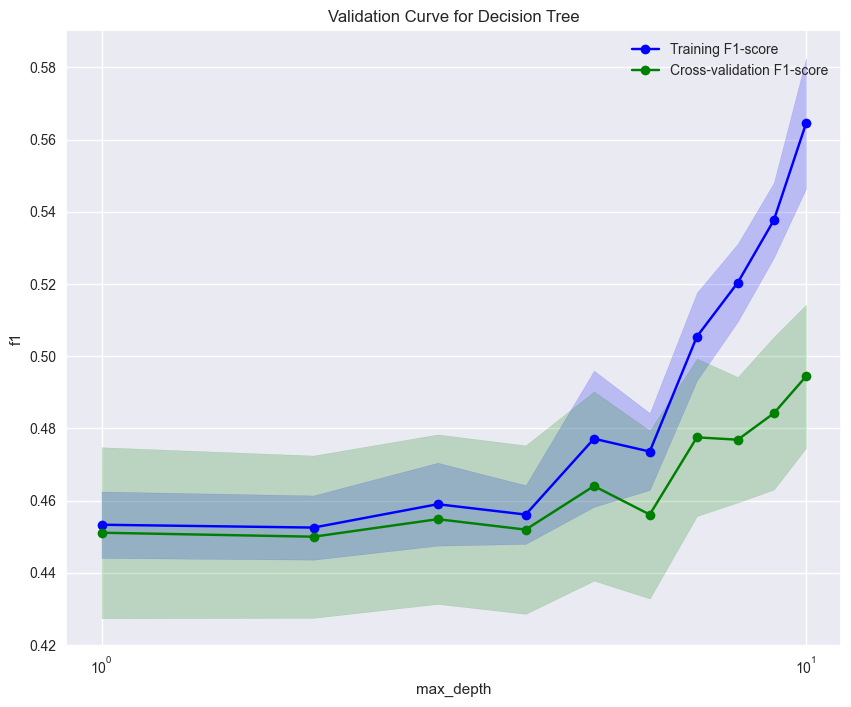

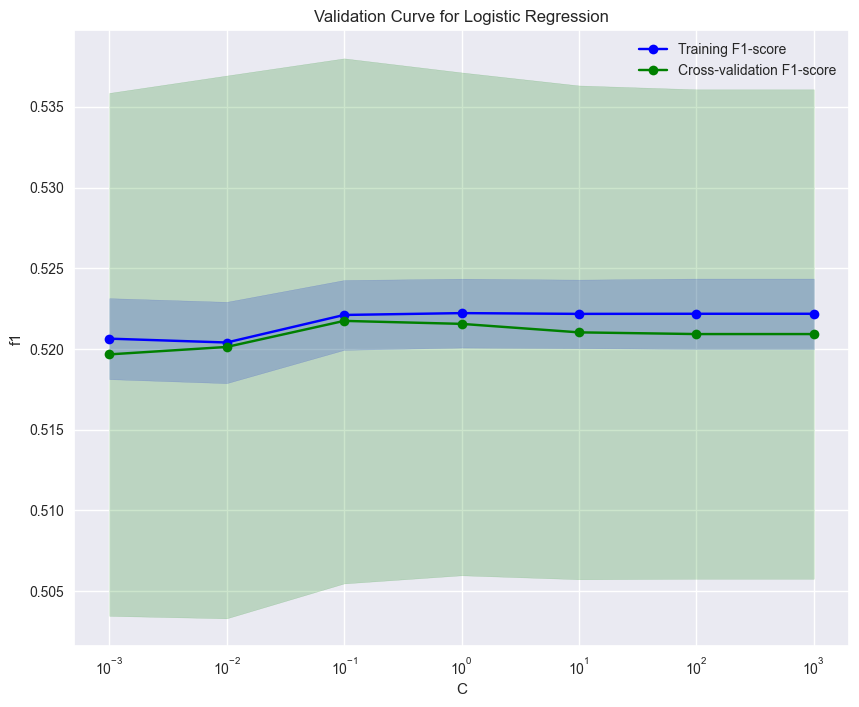

In [7]:
with mlflow.start_run(experiment_id=experiment_id, run_name='Treinamento'):

    # Carregando dataset train e test
    df_train = pd.read_parquet('..\data\processed\data_train.parquet')
    df_test = pd.read_parquet('..\data\processed\data_test.parquet')

    # Criando experimento com PyCaret
    exp = pc.setup(
        data = df_train,
        target = 'shot_made_flag',
        test_data = df_test,
        normalize = True,
        log_experiment = False,
        fold_strategy = 'stratifiedkfold'
    )

    # Treinando modelo de Regressão Logística
    lr_model = exp.create_model('lr')

    # Treinando modelo de Árvore de Decisão
    dt_model = exp.create_model('dt')

    # Avaliando Regressão Linear com a base de teste
    lr_predictions = pc.predict_model(lr_model, data=df_test.drop('shot_made_flag', axis=1))
    lr_log_loss = log_loss(df_test['shot_made_flag'], lr_predictions['prediction_label'])
    lr_f1_score = f1_score(df_test['shot_made_flag'], lr_predictions['prediction_label'])

    # Avaliando Árvore de Decisão com a base de teste
    dt_predictions = pc.predict_model(dt_model, data=df_test.drop('shot_made_flag', axis=1))
    dt_log_loss = log_loss(df_test['shot_made_flag'], dt_predictions['prediction_label'])
    dt_f1_score = f1_score(df_test['shot_made_flag'], dt_predictions['prediction_label'])

    # Plot curva de validação Árvore de Decisão
    dt_curve_val = plot_curve_validation(dt_model, x=df_train.drop(columns=['shot_made_flag']), 
                                        y=df_train['shot_made_flag'], param_name='max_depth', 
                                        param_range=np.arange(1, 11), cv=10, 
                                        scoring='f1', title_model = 'Decision Tree')

    # Plot curva de validação Regressão Logística
    lr_curve_val = plot_curve_validation(lr_model, x=df_train.drop(columns=['shot_made_flag']), 
                                        y=df_train['shot_made_flag'], param_name='C', 
                                        param_range=np.logspace(-3, 3, 7), 
                                        cv=10, title_model = 'Logistic Regression')                         
    
    # Salvando plot curva de validação 
    dt_curve_val.savefig('..plots\dt_curve_validation.png')
    lr_curve_val.savefig('..plots\lr_curve_validation.png')

    # Plot matrix confusão Árvore de Decisão
    dt_matrix = plot_confusion_matrix(dt_model, df_test, 'shot_made_flag')

    # Plot matrix confusão Regressão Logística
    lr_matrix = plot_confusion_matrix(lr_model, df_test, 'shot_made_flag')

    # Salvando plot matrix de validação 
    dt_matrix.savefig('..\plots\dt_matrix_conf.png')
    lr_matrix.savefig('..\plots\lr_matrix_conf.png')

    # Curva ROC Regressão Linear
    lr_curve = pc.plot_model(lr_model, plot='auc', save=True)
    # Renomear o arquivo
    os.rename('AUC.png', '..\plots\lr_auc.png')

    # Curva ROC Árvore de Decisão
    dt_cruve = pc.plot_model(dt_model, plot='auc', save=True)
    # Renomear o arquivo
    os.rename('AUC.png', '..\plots\dt_auc.png')
    
    # Comparando o melhor modelo
    best_model = pc.compare_models(['lr', 'dt'], n_select=1)

    # Registrando o modelo escolhido
    mlflow.sklearn.log_model(best_model, "best_model")

    # Finalizando o modelo
    best_model = exp.tune_model(lr_model,
                                optimize = 'f1',
                                search_library = 'scikit-learn',
                                search_algorithm = 'random',
                                n_iter = 10)

    # Exportando modelo
    model_pipe = exp.load_model('modelo_kobe')
    
    # Avaliando o modelo escolhido na base de teste
    lr_best_predictions = exp.predict_model(best_model, data=df_train, raw_score=True)
    lr_best_log_loss = log_loss(df_test['shot_made_flag'], lr_predictions['prediction_label'])
    lr_best_f1_score = f1_score(df_test['shot_made_flag'], lr_predictions['prediction_label'])

    # Salvando o predições de test
    yhat_test = exp.predict_model(best_model, data=df_test, raw_score=True)  
    yhat_test.to_parquet('..data\processed\prediction_test.parquet')
    mlflow.log_artifact('..data\processed\prediction_test.parquet')

    # Registrando os parânetros e metricas no MLFlow
    mlflow.log_param("normalize", True)
    mlflow.log_param("fold_strategy", 'stratifiedkfold')
    mlflow.log_param("num_folds", '10')
    mlflow.log_metric("lr_log_loss", lr_log_loss)
    mlflow.log_metric("lr_f1_score", lr_f1_score)
    mlflow.log_metric("dt_log_loss", dt_log_loss)
    mlflow.log_metric("dt_f1_score", dt_f1_score)
    mlflow.log_metric("best_model_log_loss", lr_best_log_loss)
    mlflow.log_metric("best_model_f1_score", lr_best_f1_score)

    # Logando o plot como um artefato do MLflow
    mlflow.log_artifact("..plots\dt_curve_validation.png", artifact_path="plots")
    mlflow.log_artifact("..plots\lr_curve_validation.png", artifact_path="plots")
    mlflow.log_artifact("..plots\dt_auc.png", artifact_path="plots")
    mlflow.log_artifact("..plots\lr_auc.png", artifact_path="plots")
    mlflow.log_artifact("..plots\dt_matrix_conf.png", artifact_path="plots")
    mlflow.log_artifact("..plots\lr_matrix_conf.png", artifact_path="plots")

    # Log do pepiline da modelagem do sklearn e registro da versao
    model_features = list(df_train.drop('shot_made_flag', axis=1).columns)
    inf_signature = infer_signature(df_train[model_features], 
                                    model_pipe.predict_proba(df_train.drop('shot_made_flag', axis=1)))
    input_example = df_test.drop('shot_made_flag', axis=1)

    mlflow.sklearn.log_model(
        sk_model=best_model,
        artifact_path="sklearn-model",
        registered_model_name='modelo_kobe',
        signature = inf_signature,
        input_example = input_example,
        pyfunc_predict_fn='predict'
    )

    # Criacao do cliente do servico MLFlow e atualizacao versao modelo
    model_version = -1
    client = MlflowClient()
    if model_version == -1:
        model_version = client.get_latest_versions('modelo_kobe')[-1].version

    # Registrar o modelo como staging
    client.set_registered_model_alias(
        name    = 'modelo_kobe', 
        alias   = "staging", 
        version = model_version
    )


# 6.0 Parâmetros do modelo final

In [20]:
# Importe a biblioteca necessária
from sklearn.linear_model import LogisticRegression

# Verifique os parâmetros do modelo de regressão logística
logistic_regression_params = best_model.get_params()

paranemtros_modelos = pd.DataFrame(logistic_regression_params, index=[0])
paranemtros_modelos.T

,0
C,4.996
class_weight,balanced
dual,False
fit_intercept,True
intercept_scaling,1
l1_ratio,None
max_iter,1000
multi_class,auto
n_jobs,None
penalty,l2


# 7.0 Exploração

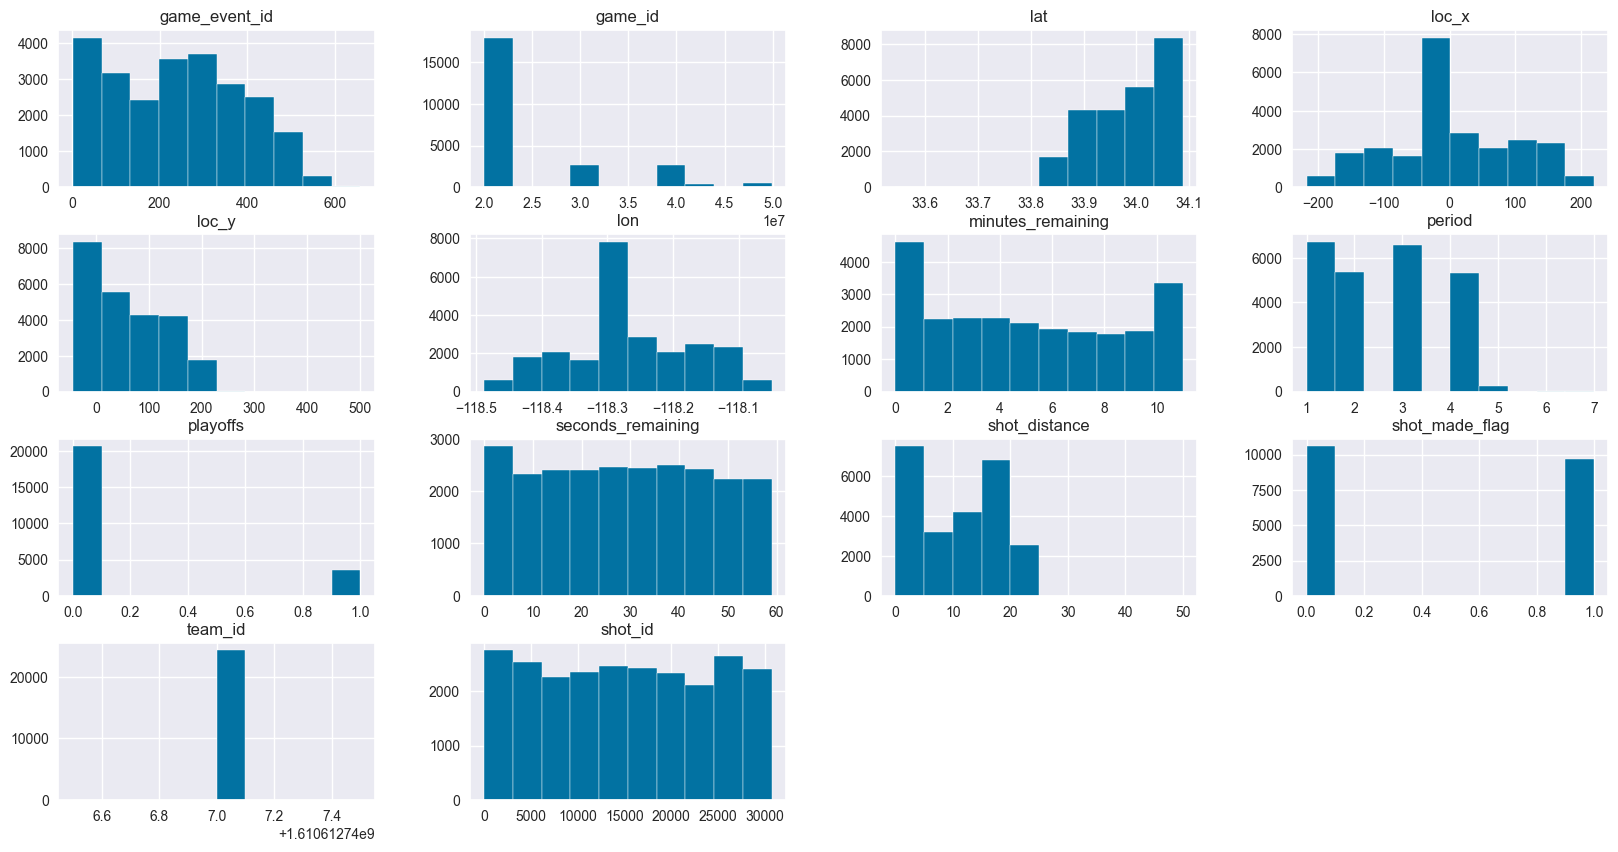

In [ ]:
# Distribuição das variaveis
distribuicao_dados = df_raw.hist(figsize=(20, 10))

In [6]:
# Tamanho dados
df_raw.shape

(24271, 25)

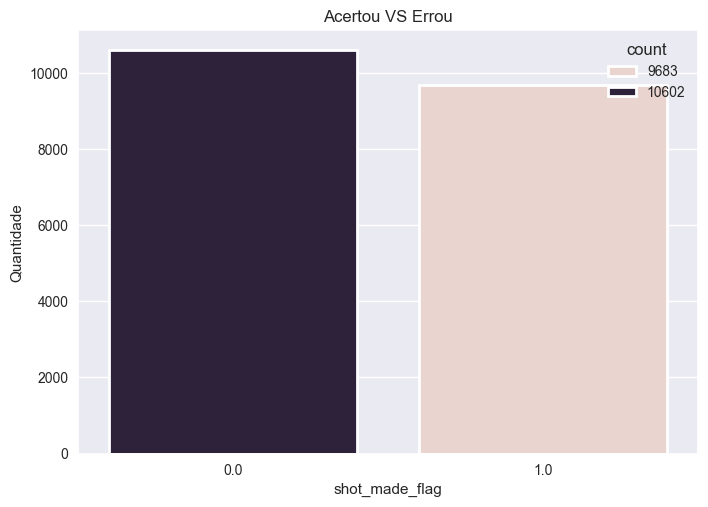

In [7]:
# Acertou vs Errou
acertos = pd.DataFrame(df_raw['shot_made_flag'].value_counts()).reset_index()

ax = sns.barplot(x='shot_made_flag', y='count', data=acertos, linewidth=2, hue='count')
plt.ylabel('Quantidade')
plt.title('Acertou VS Errou');

In [ ]:
# Distribuição da variavel mais importante base de Teste
acertos = pd.DataFrame(df_train['shot_made_flag'].value_counts()).reset_index()

ax = sns.barplot(x='shot_made_flag', y='count', data=acertos, linewidth=2, hue='count')
plt.ylabel('Quantidade')
plt.title('Dados de Teste');

In [ ]:
# Distribuição da variavel mais importante base de Treino
acertos = pd.DataFrame(df_test['shot_made_flag'].value_counts()).reset_index()

ax = sns.barplot(x='shot_made_flag', y='count', data=acertos, linewidth=2, hue='count')
plt.ylabel('Quantidade')
plt.title('Dados de Treino');